In [1]:
%matplotlib inline

In [2]:
import yaml
import logging
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Optional
from multiprocessing.pool import Pool
from multiprocessing import Queue, Manager

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

In [14]:
def mk_job_id(router_type, seed):
    return '{}:{}'.format(router_type, seed)

def un_job_id(job_id):
    [router_type, s_seed] = job_id.split(':')
    return router_type, int(s_seed)

def add_avg(df: pd.DataFrame):
    df['avg'] = df['sum'] / df['count']
    return df

def plot_data(figsize=(15,5), xlim=None, ylim=None, target='avg', **dfs):
    fig = plt.figure(figsize=figsize)
    handles = []
    min_target = 'min_' + target
    max_target = 'max_' + target
    
    for (label, df) in dfs.items():
        if min_target in df.columns:
            # this is combined data, draw errorbar
            minerr = df[target] - df[min_target]
            maxerr = df[max_target] - df[target]
            line = plt.errorbar(df['time'], df[target],
                                yerr=[minerr, maxerr], label=label)
        else:
            line, = plt.plot(df['time'], df[target], label=label)
        handles.append(line)
        
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
        
    plt.legend(handles=handles)
    plt.show()

def split_data(dct):
    results = []
    
    def add_res(i, key, val):
        while len(results) <= i:
            results.append({})
        results[i][key] = val
    
    for (key, vals) in dct.items():
        for (i, val) in enumerate(vals):
            add_res(i, key, val)
    return tuple(results)
    
def combine_launch_data(launch_data, target='avg'):
    data_unwrapped = {}
    for (job_id, data) in launch_data.items():
        router_type, seed = un_job_id(job_id)
        if router_type not in data_unwrapped:
            data_unwrapped[router_type] = []
        data_unwrapped[router_type].append(data)
    
    result_data = {}
    min_target = 'min_' + target
    max_target = 'max_' + target
    for (router_type, runs) in data_unwrapped.items():
        df = runs[0].copy()
        df[min_target] = df[target]
        df[max_target] = df[target]
        for run in runs[1:]:
            df['sum'] += run['sum']
            df['count'] += run['count']
            df[min_target] = df[min_target].combine(run[target], min)
            df[max_target] = df[max_target].combine(run[target], max)
            
        # averaging all meaningfull data across runs
        df = add_avg(df)
        df['sum'] /= len(runs) 
        df['count'] /= len(runs)
        
        result_data[router_type] = df
        
    return result_data

In [5]:
class DummyTqdmFile(object):
    """Dummy file-like that will write to tqdm"""
    file = None
    def __init__(self, file):
        self.file = file

    def write(self, x):
        # Avoid print() second call (useless \n)
        if len(x.rstrip()) > 0:
            tqdm.write(x, file=self.file)

    def flush(self):
        return getattr(self.file, "flush", lambda: None)()

@contextlib.contextmanager
def std_out_err_redirect_tqdm():
    orig_out_err = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = map(DummyTqdmFile, orig_out_err)
        yield orig_out_err[0]
    # Relay exceptions
    except Exception as exc:
        raise exc
    # Always restore sys.stdout/err if necessary
    finally:
        sys.stdout, sys.stderr = orig_out_err

In [6]:
class DummyProgressbarQueue:
    def __init__(self, bar):
        self.bar = bar
        
    def put(self, val):
        _, _, delta = val
        if delta is not None:
            self.bar.update(delta)

In [7]:
def run_network_scenario_file(file: str, router_type: str, random_seed: int = None,
                              progress_step: Optional[int] = None, progress_queue: Optional[Queue] = None,
                              series_period: int = 500,
                              series_funcs: List[str] = ['count', 'sum', 'min', 'max']):
    """
    Helper wrapper around `run_network_scenario` which should run in a separate thread.
    """
    
    # Importing here because of problemes with Tensorflow in multiple threads
    from dqnroute import event_series, run_network_scenario, DQNROUTE_LOGGER, TF_MODELS_DIR

    logger = logging.getLogger(DQNROUTE_LOGGER)
    TF_MODELS_DIR = '../tf_models'
    #logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    
    with open(file) as f:
        run_params = yaml.safe_load(f)
    
    series = event_series(series_period, series_funcs)
    series = run_network_scenario(run_params, router_type, series, random_seed=random_seed,
                                  progress_step=progress_step, progress_queue=progress_queue)
    return add_avg(series.getSeries())

def run_conveyor_scenario_file(file: str, router_type: str, random_seed: int = None,
                               progress_step: Optional[int] = None, progress_queue: Optional[Queue] = None,
                               series_period: int = 500,
                               series_funcs: List[str] = ['count', 'sum', 'min', 'max']):
    """
    Helper wrapper around `run_conveyor_scenario` which should run in a separate thread.
    """
    
    from dqnroute import event_series, run_conveyor_scenario, DQNROUTE_LOGGER, TF_MODELS_DIR

    logger = logging.getLogger(DQNROUTE_LOGGER)
    TF_MODELS_DIR = '../tf_models'
    #logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    
    with open(file) as f:
        run_params = yaml.safe_load(f)
    
    time_series = event_series(series_period, series_funcs)
    energy_series = event_series(series_period, series_funcs)
    
    time_series, energy_series = \
        run_conveyor_scenario(run_params, router_type, time_series, energy_series,
                              random_seed=random_seed,
                              progress_step=progress_step, progress_queue=progress_queue)
    
    return add_avg(time_series.getSeries()), add_avg(energy_series.getSeries())

def run_threaded(func, router_types: List[str], random_seeds: List[int], *args, **kwargs):
    """
    Runs several scenario runners in multiple threads and displays progress bars for them
    """

    pool = Pool()
    m = Manager()
    queue = m.Queue()
    jobs = {}
    bars = {}
    for router_type in router_types:
        for seed in random_seeds:
            job_id = mk_job_id(router_type, seed)
            job_args = dict(kwargs, router_type=router_type, random_seed=seed,
                            progress_queue=queue)
            jobs[job_id] = pool.apply_async(func, args=args, kwds=job_args,
                                            error_callback=print)
            bars[job_id] = tqdm(desc=job_id)

    # TODO: fix progressbars somehow
    while len(bars) > 0:
        (rt, s, val) = queue.get()
        job_id = mk_job_id(rt, s)
        if val is None:
            bars.pop(job_id).close()
        else:
            bars[job_id].update(val)
        
    results = {job_id: job.get() for (job_id, job) in jobs.items()}
    
    if type(next(iter(results.values()))) is tuple:
        return split_data(results)
    return results

In [8]:
launch6_data_mult = run_threaded(run_network_scenario_file, random_seeds=[42, 43, 44],
                                 file='../launches/launch6.yaml', router_types=['simple_q', 'link_state', 'dqn'],
                                 progress_step=500)

simple_q:42: 0it [00:00, ?it/s]
simple_q:43: 0it [00:00, ?it/s]

simple_q:44: 0it [00:00, ?it/s]


link_state:42: 0it [00:00, ?it/s]



link_state:43: 0it [00:00, ?it/s]




link_state:44: 0it [00:00, ?it/s]





dqn:42: 0it [00:00, ?it/s]






dqn:43: 0it [00:00, ?it/s]







dqn:44: 0it [00:00, ?it/s]Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
simple_q:42: 2000it [00:26, 55.19it/s]
simple_q:42: 2500it [00:26, 77.79it/s]
simple_q:42: 3000it [00:27, 109.28it/s]

simple_q:44: 500it [00:27, 18.37it/s]
simple_q:42: 3500it [00:27, 152.69it/s]

simple_q:42: 4000it [00:27, 211.61it/s]
simple_q:43: 2000it [00:27, 53.23it/s]

simple_q:42: 4500it [00:27, 289.88it/s]
simple_q:42: 5000it [00:28, 389.44it/s]

simple_q:44: 2000it [00:28, 52.40it/s]
simple_q:42: 5500it [00:28, 510.60it/s]

simple_q:44: 2500it [00:28, 73.75it/s]
simple_q:42: 6000it [00:28, 654.75it/s]

simple_q:44: 3000it [00:28, 103.50it/s]


link_state:42: 500it [00:28, 

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 6000it [00:44, 464.23it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:44: 3500it [00:44, 94.00it/s]
link_state:43: 6500it [00:45, 558.29it/s]
link_state:44: 4500it [00:45, 183.09it/s]
link_state:44: 5000it [00:45, 251.13it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 7000it [00:45, 627.98it/s]
link_state:44: 5500it [00:45, 340.99it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 7500it [00:46, 709.12it/s]
link_state:44: 6500it [00:46, 561.32it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 8000it [00:46, 775.24it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 8500it [00:47, 832.68it/s]
link_state:44: 7500it [00:47, 761.41it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 9000it [00:47, 874.58it/s]
link_state:44: 8000it [00:47, 833.96it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 9500it [00:48, 919.18it/s]
link_state:43: 10000it [00:48, 961.81it/s]
link_state:44: 9000it [00:48, 926.98it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 11000it [00:49, 974.45it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 11500it [00:50, 1011.88it/s]
link_state:43: 12000it [00:50, 1064.69it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 12500it [00:51, 1128.13it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 13000it [00:51, 1095.68it/s]
link_state:43: 13500it [00:51, 1164.64it/s]
link_state:44: 12000it [00:52, 1001.56it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 14000it [00:52, 1194.00it/s]
link_state:43: 14500it [00:52, 1187.64it/s]
link_state:43: 15000it [00:53, 1209.84it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:44: 13500it [00:53, 1112.74it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 15500it [00:53, 1237.51it/s]
link_state:44: 14500it [00:54, 1163.06it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:44: 15500it [00:54, 1227.57it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:44: 16500it [00:55, 1675.38it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



dqn:42: 500it [00:58,  8.59it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



dqn:42: 1000it [01:01, 12.02it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



dqn:42: 1500it [01:05, 16.48it/s]

dqn:44: 500it [01:06,  7.52it/s]
dqn:42: 2000it [01:08, 22.51it/s]

dqn:44: 1000it [01:08, 10.60it/s]
dqn:42: 2500it [01:12, 29.92it/s]

dqn:44: 1500it [01:12, 14.63it/s]
dqn:43: 3000it [01:15, 38.95it/s]

dqn:42: 3500it [01:19, 49.69it/s]
dqn:43: 3500it [01:19, 49.34it/s]

dqn:42: 4000it [01:23, 62.13it/s]
dqn:43: 4000it [01:23, 60.65it/s]

dqn:42: 4500it [01:26, 75.14it/s]
dqn:43: 4500it [01:27, 72.65it/s]

dqn:42: 5000it [01:30, 86.58it/s]
dqn:43: 5000it [01:30, 84.48it/s]

dqn:42: 5500it [01:34, 92.20it/s]
dqn:43: 5500it [01:35, 90.37it/s]

dqn:42: 6000it [01:38, 99.66it/s]
dqn:43: 6000it [01:39, 99.12it/s]

dqn:44: 5000it [01:41, 73.59it/s]

dqn:44: 5500it [01:47, 77.79it/s]
dqn:42: 6000it [01:49, 99.66it/s]

dqn:44: 6000it [01:52, 81.82it/s]
dqn:42: 6500it [01:55, 59.36it/s]

dqn:44: 6500it [02:09, 53.65it/s]
dqn:42: 6500it [02:09, 59.36it/s]
dqn:42: 7000it [02:12, 45.01it/s]

dqn:44: 6500it [02:19, 53.65it/s]

dqn:44: 7000it [02:23, 45.95it/s]

In [9]:
launch6_data_comb = combine_launch_data(launch6_data_mult)

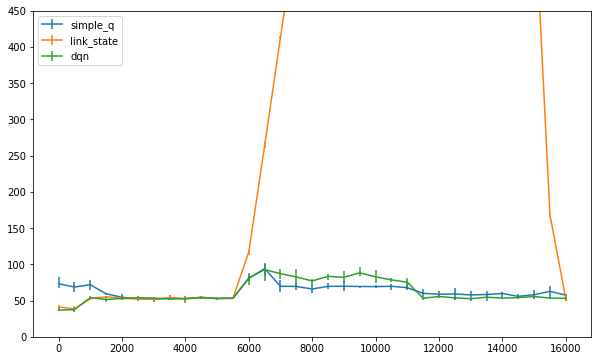

In [10]:
plot_data(figsize=(10,6), ylim=(0,450), **launch6_data_comb)

In [8]:
%%time
launch8_data = run_threaded(run_network_scenario_file, file='../launches/launch8.yaml',
                            router_types=['simple_q', 'link_state', 'dqn'], progress_step=500,
                            random_seeds=[42, 43, 44])

launch8_data_comb = combine_launch_data(launch8_data)

simple_q:42: 0it [00:00, ?it/s]
simple_q:43: 0it [00:00, ?it/s]

simple_q:44: 0it [00:00, ?it/s]


link_state:42: 0it [00:00, ?it/s]



link_state:43: 0it [00:00, ?it/s]




link_state:44: 0it [00:00, ?it/s]





dqn:42: 0it [00:00, ?it/s]






dqn:43: 0it [00:00, ?it/s]







dqn:44: 0it [00:00, ?it/s]Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


simple_q:44: 500it [00:26, 18.59it/s]

simple_q:42: 500it [00:27, 18.30it/s]

simple_q:42: 1000it [00:27, 26.02it/s]

simple_q:42: 2000it [00:28, 52.27it/s]

simple_q:44: 2500it [00:28, 74.39it/s]


link_state:42: 500it [00:28, 17.65it/s]
simple_q:42: 2500it [00:28, 73.45it/s]

simple_q:44: 3000it [00:28, 103.33it/s]


simple_q:42: 3000it [00:28, 102.97it/s]
simple_q:43: 1000it [00:28, 24.89it/s]


link_state:42: 1500it [00:28, 35.62it/s]

simple_q:42: 3500it [00:29, 142.59it/s]


link_state:42: 2000it [00:29, 50.43it/s]
simple_q:43: 1500it [00:29, 35.23it/s]

simple_q:42: 4000it [

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 4500it [00:57, 143.65it/s]
link_state:43: 5500it [00:57, 274.96it/s]
link_state:43: 6000it [00:57, 373.14it/s]
link_state:43: 6500it [00:58, 478.72it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 7000it [00:58, 585.64it/s]
link_state:43: 7500it [00:58, 724.55it/s]
link_state:43: 8000it [00:59, 865.04it/s]
link_state:44: 6000it [00:59, 351.22it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 8500it [00:59, 985.95it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 9000it [01:00, 1075.84it/s]
link_state:43: 9500it [01:00, 1197.65it/s]
link_state:43: 10000it [01:00, 1219.59it/s]
link_state:43: 10500it [01:01, 1303.63it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 11000it [01:01, 1307.82it/s]
link_state:43: 11500it [01:01, 1256.97it/s]
link_state:43: 12000it [01:02, 1284.47it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 12500it [01:02, 1345.71it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 13000it [01:02, 1325.24it/s]
link_state:43: 13500it [01:03, 1404.11it/s]
link_state:43: 14000it [01:03, 1444.12it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 14500it [01:03, 1551.58it/s]
link_state:43: 15000it [01:04, 1628.77it/s]
link_state:43: 15500it [01:04, 1559.49it/s]
link_state:44: 13000it [01:04, 1367.02it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 16000it [01:04, 1582.83it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 16500it [01:05, 1504.58it/s]
link_state:43: 17000it [01:05, 1364.25it/s]
link_state:44: 14500it [01:05, 1471.04it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 17500it [01:05, 1364.86it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 18000it [01:06, 1347.99it/s]
link_state:43: 18500it [01:06, 1309.95it/s]
link_state:43: 19000it [01:07, 1274.96it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 19500it [01:07, 1304.56it/s]
link_state:43: 20000it [01:07, 1282.70it/s]
link_state:43: 20500it [01:08, 1373.26it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 21000it [01:08, 1450.80it/s]
link_state:43: 21500it [01:08, 1564.72it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 22500it [01:09, 1919.49it/s]
link_state:43: 23000it [01:09, 1820.03it/s]
link_state:43: 24000it [01:09, 1972.40it/s]
link_state:44: 20500it [01:09, 1390.21it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 24500it [01:10, 1818.13it/s]
link_state:44: 21000it [01:10, 1454.98it/s]
link_state:43: 25000it [01:10, 1653.08it/s]
link_state:43: 26000it [01:11, 1799.83it/s]
link_state:43: 26500it [01:11, 1714.86it/s]
link_state:44: 23000it [01:11, 1563.04it/s]
link_state:43: 27000it [01:11, 1613.26it/s]
link_state:43: 27500it [01:12, 1648.47it/s]
link_state:43: 28000it [01:12, 1773.42it/s]
link_state:43: 28500it [01:12, 1714.23it/s]
link_state:43: 29500it [01:13, 1880.25it/s]
link_state:43: 30000it [01:13, 1871.66it/s]
link_state:43: 30500it [01:13, 1714.64it/s]
link_state:43: 31000it [01:14, 1688.33it/s]
link_state:43: 31500it [01:14, 1647.53it/s]
link_state:44: 28000it [01:14, 1602.40it/s]

link_state:43: 32000it [01:14, 1657.63it/s]
link_state:43: 32500it [01:14, 1696.26it/s]
link_state:43: 33000it [01:15, 1811.67it/s]
link_state:43: 33500it [01:15, 1647.87it/s]
link_state:43: 34000it [01:15, 1717.33it/s]
link_state:43: 34500it [01:16, 1795.37it/s]


dqn:43: 500it [01:16,  6.57it

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:44: 35000it [01:18, 1787.25it/s]
link_state:44: 36500it [01:19, 460.78it/s] 

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



dqn:43: 1000it [01:19,  9.21it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


dqn:42: 1500it [01:22, 12.93it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



dqn:43: 1500it [01:23, 12.74it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


dqn:42: 2000it [01:26, 17.72it/s]
dqn:43: 2000it [01:27, 17.43it/s]

dqn:42: 2500it [01:29, 24.10it/s]
dqn:43: 2500it [01:31, 23.64it/s]

dqn:42: 3000it [01:33, 32.00it/s]
dqn:43: 3000it [01:34, 31.80it/s]

dqn:42: 3500it [01:36, 41.89it/s]
dqn:43: 3500it [01:38, 41.20it/s]

dqn:42: 4000it [01:40, 53.16it/s]
dqn:43: 4000it [01:41, 52.09it/s]

dqn:42: 4500it [01:44, 64.02it/s]
dqn:43: 4500it [01:45, 63.21it/s]

dqn:42: 5000it [01:48, 76.81it/s]
dqn:43: 5000it [01:49, 74.62it/s]

dqn:42: 5500it [01:51, 87.80it/s]
dqn:43: 5500it [01:53, 87.47it/s]

dqn:42: 6000it [01:55, 98.59it/s]
dqn:43: 6000it [01:56, 99.34it/s]

dqn:42: 6500it [02:00, 96.07it/s]

dqn:44: 5000it [02:01, 69.95it/s]
dqn:43: 6500it [02:02, 95.01it/s]

dqn:42: 7000it [02:08, 85.54it/s]
dqn:43: 7000it [02:09, 87.66it/s]

dqn:42: 7500it [02:15, 80.68it/s]

dqn:44: 6500it [02:15, 86.61it/s]
dqn:43: 7500it [02:16, 80.48it/s]
dqn:42: 8000it [02:22, 77.35it/s]

dqn:44: 7000it [02:23, 79.84it/s]
dqn:42: 8500it [02:29, 75.11it/s]


CPU times: user 2.94 s, sys: 554 ms, total: 3.49 s
Wall time: 8min 9s


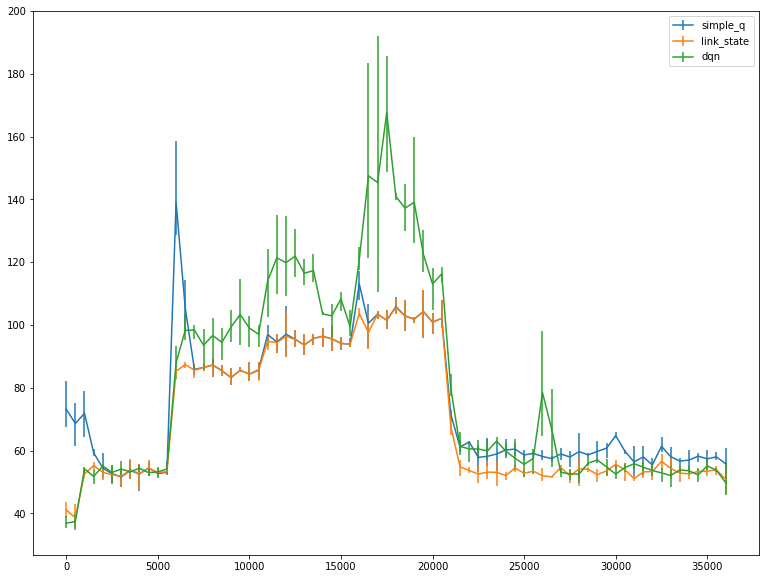

In [9]:
plot_data(figsize=(13,10), **launch8_data_comb)

In [11]:
conveyor_data_full = run_threaded(run_conveyor_scenario_file, file='../launches/conveyor_energy_test.yaml',
                                  router_types=['simple_q', 'link_state', 'dqn'], progress_step=500,
                                  random_seeds=[42, 43, 44])

simple_q:42: 0it [00:00, ?it/s]
simple_q:43: 0it [00:00, ?it/s]

simple_q:44: 0it [00:00, ?it/s]


link_state:42: 0it [00:00, ?it/s]



link_state:43: 0it [00:00, ?it/s]




link_state:44: 0it [00:00, ?it/s]





dqn:42: 0it [00:00, ?it/s]






dqn:43: 0it [00:00, ?it/s]







dqn:44: 0it [00:00, ?it/s]Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.



link_state:42: 500it [00:27, 18.43it/s]


link_state:42: 1000it [00:27, 26.25it/s]
simple_q:43: 500it [00:27, 18.26it/s]


link_state:42: 1500it [00:27, 37.33it/s]
simple_q:43: 1000it [00:27, 26.01it/s]


link_state:42: 2000it [00:27, 52.96it/s]
simple_q:43: 1500it [00:27, 36.99it/s]


link_state:42: 2500it [00:27, 74.95it/s]
simple_q:43: 2000it [00:27, 52.48it/s]


link_state:42: 3000it [00:28, 105.61it/s]
simple_q:42: 500it [00:28, 17.62it/s]
simple_q:43: 3000it [00:28, 104.55it/s]


simple_q:42: 1000it [00:28, 25.10it/s]
simple_q:43: 3500it [00:28, 145.96it/s]


simple_q:42: 20

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64




link_state:44: 4500it [00:44, 189.36it/s]
simple_q:44: 27500it [00:44, 2312.81it/s]

link_state:44: 5000it [00:44, 261.04it/s]
simple_q:44: 28500it [00:44, 639.92it/s] 
link_state:43: 8000it [00:44, 1186.01it/s]
link_state:43: 8500it [00:44, 1412.94it/s]
link_state:43: 9000it [00:45, 1633.10it/s]
link_state:44: 7000it [00:45, 829.83it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:43: 9500it [00:45, 1774.69it/s]
link_state:43: 10000it [00:45, 1956.89it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64



link_state:43: 10500it [00:45, 2100.34it/s]
link_state:43: 11000it [00:45, 2271.43it/s]
link_state:43: 11500it [00:46, 2194.20it/s]
link_state:44: 9500it [00:46, 1816.72it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:43: 12000it [00:46, 2289.23it/s]
link_state:44: 10000it [00:46, 1914.95it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:43: 12500it [00:46, 2434.54it/s]
link_state:43: 13500it [00:46, 2561.21it/s]
link_state:43: 14500it [00:47, 2594.54it/s]
link_state:43: 15000it [00:47, 2275.88it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64



link_state:44: 12000it [00:47, 1695.54it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:43: 15500it [00:47, 2195.79it/s]
link_state:43: 16000it [00:47, 2251.00it/s]
link_state:44: 13000it [00:47, 1987.15it/s]
link_state:43: 16500it [00:48, 2250.39it/s]
link_state:43: 17000it [00:48, 2220.45it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64



link_state:43: 17500it [00:48, 2331.17it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64



link_state:43: 18000it [00:48, 2413.16it/s]
link_state:43: 18500it [00:49, 2415.34it/s]
link_state:43: 19500it [00:49, 2408.09it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64



link_state:43: 20000it [00:49, 2450.08it/s]
link_state:44: 17000it [00:49, 2318.98it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:43: 20500it [00:49, 2502.32it/s]
link_state:44: 17500it [00:49, 2389.74it/s]
link_state:43: 21000it [00:50, 2365.18it/s]
link_state:43: 21500it [00:50, 2267.19it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64



link_state:43: 22000it [00:50, 2325.90it/s]
link_state:43: 22500it [00:50, 2376.10it/s]
link_state:44: 20000it [00:50, 2703.92it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:43: 23000it [00:50, 2452.91it/s]
link_state:43: 23500it [00:51, 2552.99it/s]
link_state:43: 24000it [00:51, 2469.57it/s]
link_state:44: 21500it [00:51, 2613.17it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:43: 24500it [00:51, 2551.67it/s]
link_state:43: 25000it [00:51, 2683.22it/s]
link_state:43: 25500it [00:51, 2737.08it/s]
link_state:44: 23000it [00:51, 2671.38it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:43: 26000it [00:52, 2717.99it/s]
link_state:43: 26500it [00:52, 2713.36it/s]
link_state:43: 27000it [00:52, 2562.00it/s]
link_state:43: 27500it [00:52, 2659.17it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64



link_state:44: 25500it [00:52, 2450.48it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:44: 27000it [00:53, 2436.42it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:44: 27500it [00:53, 2454.74it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64


link_state:44: 28500it [00:53, 528.41it/s] 

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Rest

dqn:42: 500it [01:11,  7.01it/s]
dqn:43: 500it [01:11,  6.99it/s]

dqn:44: 500it [01:16,  6.51it/s]
dqn:42: 1000it [01:17,  9.63it/s]
dqn:43: 1500it [01:23, 13.14it/s]

dqn:42: 1500it [01:23, 13.11it/s]

dqn:44: 1500it [01:29, 12.25it/s]
dqn:42: 2000it [01:30, 17.40it/s]
dqn:43: 2500it [01:35, 23.10it/s]

dqn:42: 2500it [01:36, 22.78it/s]
dqn:43: 3000it [01:41, 29.46it/s]

dqn:42: 3000it [01:43, 28.79it/s]
dqn:43: 3500it [01:47, 36.84it/s]

dqn:42: 3500it [01:49, 36.17it/s]
dqn:43: 4000it [01:53, 43.70it/s]

dqn:42: 4000it [01:55, 43.29it/s]

dqn:44: 4000it [01:59, 42.38it/s]
dqn:42: 4500it [02:01, 50.19it/s]

dqn:44: 4500it [02:05, 49.66it/s]
dqn:42: 5000it [02:07, 56.11it/s]

dqn:44: 5000it [02:11, 55.70it/s]
dqn:42: 5500it [02:14, 60.61it/s]

dqn:44: 5500it [02:18, 60.97it/s]
dqn:42: 6000it [02:21, 64.93it/s]

dqn:44: 6000it [02:25, 63.52it/s]
dqn:42: 6500it [02:27, 69.83it/s]

dqn:44: 6500it [02:31, 67.72it/s]
dqn:42: 7000it [02:34, 68.17it/s]
dqn:43: 7500it [02:38, 72.49it/s]

dqn

In [12]:
conveyor_data_time, conveyor_data_nrg = conveyor_data_full

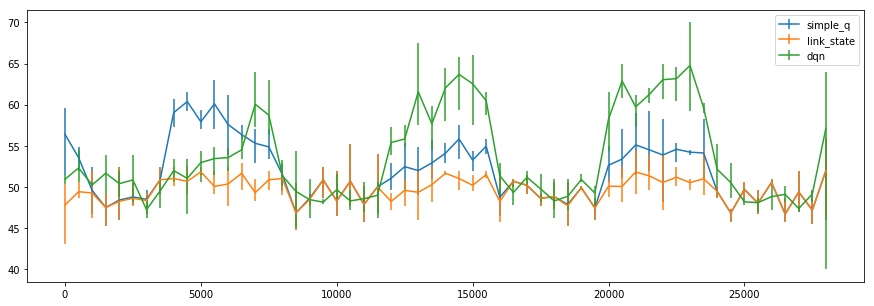

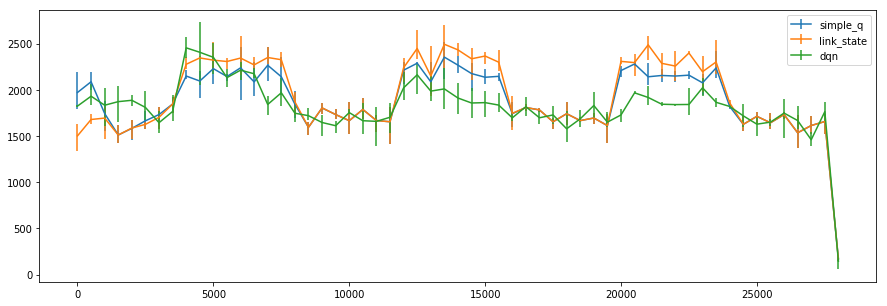

In [15]:
conveyor_data_time_comb = combine_launch_data(conveyor_data_time)
conveyor_data_nrg_comb = combine_launch_data(conveyor_data_nrg, target='sum')

plot_data(**conveyor_data_time_comb)
plot_data(**conveyor_data_nrg_comb, target='sum')

In [21]:
conveyor2_data_full = run_threaded(run_conveyor_scenario_file, file='../launches/conveyor_energy_test_2.yaml',
                                   router_types=['link_state', 'simple_q', 'dqn'], progress_step=500,
                                   random_seeds=[42, 43, 44])


link_state:42: 0it [00:00, ?it/s]

link_state:43: 0it [00:00, ?it/s]


link_state:44: 0it [00:00, ?it/s]



simple_q:42: 0it [00:00, ?it/s]




simple_q:43: 0it [00:00, ?it/s]





simple_q:44: 0it [00:00, ?it/s]






dqn:42: 0it [00:00, ?it/s]







dqn:43: 0it [00:00, ?it/s]








dqn:44: 0it [00:00, ?it/s]Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


link_state:43: 500it [00:28, 17.64it/s]
link_state:42: 500it [00:28, 17.59it/s]

link_state:43: 1000it [00:28, 25.14it/s]
link_state:42: 1000it [00:28, 25.05it/s]


link_state:44: 500it [00:28, 17.46it/s]

link_state:43: 1500it [00:28, 35.78it/s]
link_state:42: 1500it [00:28, 35.65it/s]



simple_q:42: 500it [00:28, 17.35it/s]


link_state:44: 1000it [00:28, 24.87it/s]

link_state:43: 2000it [00:28, 50.79it/s]
link_state:42: 2000it [00:29, 50.60it/s]



simple_q:42: 1000it [00:29, 24.70it/s]


link_state:44: 1500it [00:29, 35.36it/s]

link_state:43: 2500it [00:29, 71.71it/

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64





simple_q:44: 3500it [00:56, 74.93it/s]

simple_q:43: 3500it [00:56, 74.70it/s]


simple_q:44: 4000it [00:56, 105.75it/s]

simple_q:43: 4000it [00:56, 105.06it/s]


simple_q:44: 4500it [00:56, 148.41it/s]
simple_q:42: 36000it [00:56, 726.92it/s]
simple_q:42: 36500it [00:56, 640.97it/s]

simple_q:44: 5000it [00:57, 205.70it/s]
simple_q:43: 4500it [00:57, 145.83it/s]

simple_q:44: 5500it [00:57, 282.45it/s]
simple_q:43: 5000it [00:57, 201.75it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 6000it [00:57, 381.87it/s]
simple_q:43: 5500it [00:57, 277.09it/s]

simple_q:44: 6500it [00:57, 503.62it/s]
simple_q:43: 6000it [00:57, 374.58it/s]

simple_q:44: 7000it [00:57, 651.74it/s]
simple_q:43: 6500it [00:58, 498.83it/s]

simple_q:44: 7500it [00:58, 833.85it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 7000it [00:58, 639.30it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 8000it [00:58, 1028.16it/s]
simple_q:43: 7500it [00:58, 802.93it/s]

simple_q:44: 8500it [00:58, 1229.13it/s]
simple_q:43: 8000it [00:58, 1011.36it/s]

simple_q:44: 9000it [00:58, 1419.69it/s]
simple_q:43: 8500it [00:58, 1221.96it/s]

simple_q:44: 9500it [00:59, 1567.12it/s]
simple_q:43: 9000it [00:59, 1420.95it/s]

simple_q:44: 10000it [00:59, 1803.63it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 9500it [00:59, 1636.13it/s]

simple_q:44: 10500it [00:59, 1950.35it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 10000it [00:59, 1793.03it/s]

simple_q:44: 11000it [00:59, 2071.17it/s]
simple_q:43: 10500it [00:59, 1884.07it/s]

simple_q:44: 11500it [00:59, 2212.82it/s]
simple_q:43: 11000it [01:00, 1946.49it/s]

simple_q:44: 12000it [01:00, 2203.88it/s]
simple_q:43: 11500it [01:00, 2113.97it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 12500it [01:00, 2283.58it/s]
simple_q:43: 12000it [01:00, 2149.41it/s]

simple_q:44: 13000it [01:00, 2279.17it/s]
simple_q:43: 12500it [01:00, 2147.89it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 13500it [01:00, 2226.81it/s]
simple_q:43: 13000it [01:00, 2107.88it/s]

simple_q:44: 14000it [01:01, 2173.00it/s]
simple_q:43: 13500it [01:01, 2278.76it/s]

simple_q:44: 14500it [01:01, 2329.04it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 14000it [01:01, 2361.66it/s]

simple_q:44: 15000it [01:01, 2386.47it/s]
simple_q:43: 14500it [01:01, 2301.60it/s]

simple_q:44: 15500it [01:01, 2433.50it/s]
simple_q:43: 15000it [01:01, 2298.60it/s]

simple_q:44: 16000it [01:01, 2460.49it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 15500it [01:02, 2141.03it/s]

simple_q:44: 16500it [01:02, 1921.67it/s]
simple_q:43: 16000it [01:02, 2143.89it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 17000it [01:02, 1664.47it/s]
simple_q:43: 16500it [01:02, 1796.10it/s]

simple_q:44: 17500it [01:03, 1447.95it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 17000it [01:03, 1494.49it/s]

simple_q:44: 18000it [01:03, 1311.96it/s]
simple_q:43: 17500it [01:03, 1317.47it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 18500it [01:04, 1155.21it/s]
simple_q:43: 18000it [01:04, 1250.85it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 19000it [01:04, 1183.99it/s]
simple_q:43: 18500it [01:04, 1215.42it/s]

simple_q:44: 19500it [01:04, 1185.29it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 19000it [01:04, 1185.35it/s]

simple_q:44: 20000it [01:05, 1182.17it/s]
simple_q:43: 19500it [01:05, 1218.02it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 20000it [01:05, 1245.09it/s]

simple_q:44: 20500it [01:05, 1147.03it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 20500it [01:06, 1188.86it/s]

simple_q:44: 21000it [01:06, 1112.41it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 21000it [01:06, 1144.98it/s]

simple_q:44: 21500it [01:06, 1065.12it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 21500it [01:07, 1112.91it/s]

simple_q:44: 22000it [01:07, 1080.64it/s]
simple_q:43: 22000it [01:07, 1109.27it/s]

simple_q:44: 22500it [01:07, 1087.01it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 23000it [01:08, 1053.86it/s]
simple_q:43: 22500it [01:08, 1002.52it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 23000it [01:08, 1030.33it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 23500it [01:08, 946.24it/s] 
simple_q:43: 23500it [01:09, 1008.58it/s]

simple_q:44: 24000it [01:09, 967.26it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 24000it [01:09, 1021.83it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 24500it [01:09, 957.93it/s]
simple_q:43: 24500it [01:10, 995.11it/s] 

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 25000it [01:10, 919.94it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 25000it [01:10, 989.97it/s]

simple_q:44: 25500it [01:10, 941.47it/s]
simple_q:43: 25500it [01:11, 944.07it/s]

simple_q:44: 26000it [01:11, 970.17it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 26000it [01:11, 962.16it/s]

simple_q:44: 26500it [01:11, 931.13it/s]
simple_q:43: 26500it [01:12, 975.52it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 27000it [01:12, 927.81it/s]
simple_q:43: 27000it [01:12, 991.50it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 27500it [01:13, 890.79it/s]
simple_q:43: 27500it [01:13, 988.15it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 28000it [01:13, 1023.70it/s]

simple_q:44: 28000it [01:13, 867.05it/s]
simple_q:43: 28500it [01:14, 981.31it/s] 

simple_q:44: 28500it [01:14, 810.60it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 29000it [01:14, 962.30it/s]

simple_q:44: 29000it [01:15, 786.12it/s]
simple_q:43: 29500it [01:15, 948.53it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 29500it [01:15, 782.77it/s]
simple_q:43: 30000it [01:15, 935.93it/s]

simple_q:44: 30000it [01:16, 792.92it/s]
simple_q:43: 30500it [01:16, 919.04it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 31000it [01:17, 911.99it/s]

simple_q:44: 30500it [01:17, 786.11it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 31500it [01:17, 888.46it/s]

simple_q:44: 31000it [01:17, 801.37it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 32000it [01:18, 896.27it/s]

simple_q:44: 31500it [01:18, 812.80it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



simple_q:43: 32500it [01:18, 859.68it/s]

simple_q:44: 32000it [01:18, 823.12it/s]

simple_q:44: 32500it [01:19, 824.05it/s]
simple_q:43: 33000it [01:19, 804.03it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 33000it [01:20, 790.98it/s]
simple_q:43: 33500it [01:20, 782.64it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




simple_q:44: 33500it [01:20, 781.61it/s]
simple_q:43: 34000it [01:20, 766.31it/s]

simple_q:44: 34000it [01:21, 792.85it/s]
simple_q:43: 34500it [01:21, 738.85it/s]

simple_q:44: 34500it [01:22, 779.76it/s]
simple_q:43: 35000it [01:22, 746.19it/s]

simple_q:44: 35000it [01:22, 797.88it/s]
simple_q:43: 35500it [01:22, 753.93it/s]

simple_q:44: 35500it [01:23, 773.78it/s]
simple_q:43: 36000it [01:23, 764.85it/s]
simple_q:43: 36500it [01:23, 1004.37it/s]

simple_q:44: 36000it [01:24, 735.83it/s]
simple_q:44: 36500it [01:24, 433.66it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



dqn:42: 500it [01:27,  5.73it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




dqn:43: 500it [01:29,  5.59it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



dqn:42: 1000it [01:35,  7.86it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




dqn:43: 1000it [01:38,  7.66it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64



dqn:42: 1500it [01:44, 10.62it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_conveyor_test_ng_ff_relu_64_64




dqn:43: 1500it [01:46, 10.39it/s]
dqn:42: 2000it [01:51, 14.22it/s]


dqn:44: 500it [01:53,  4.42it/s]

dqn:43: 2000it [01:53, 13.93it/s]
dqn:42: 2500it [01:58, 18.64it/s]

dqn:43: 2500it [02:00, 18.51it/s]


dqn:44: 1000it [02:00,  6.14it/s]

dqn:43: 3000it [02:06, 23.91it/s]
dqn:42: 3000it [02:06, 23.65it/s]


dqn:44: 1500it [02:07,  8.47it/s]
dqn:42: 3500it [02:13, 29.90it/s]

dqn:43: 3500it [02:13, 29.97it/s]


dqn:44: 2000it [02:14, 11.53it/s]
dqn:42: 4000it [02:20, 36.37it/s]

dqn:43: 4000it [02:20, 36.61it/s]


dqn:44: 2500it [02:22, 15.30it/s]
dqn:42: 4500it [02:26, 43.42it/s]

dqn:43: 4500it [02:26, 43.29it/s]


dqn:44: 3000it [02:28, 20.04it/s]
dqn:42: 5000it [02:33, 49.42it/s]

dqn:43: 5000it [02:33, 49.08it/s]


dqn:44: 3500it [02:35, 25.85it/s]
dqn:42: 5500it [02:40, 54.38it/s]

dqn:43: 5500it [02:40, 54.04it/s]


dqn:44: 4000it [02:41, 32.30it/s]
dqn:42: 6000it [02:46, 59.70it/s]


dqn:44: 4500it [02:47, 39.45it/s]

dqn:43: 6000it [02:48, 57.12it/s]
dqn:42: 6500it [02:5

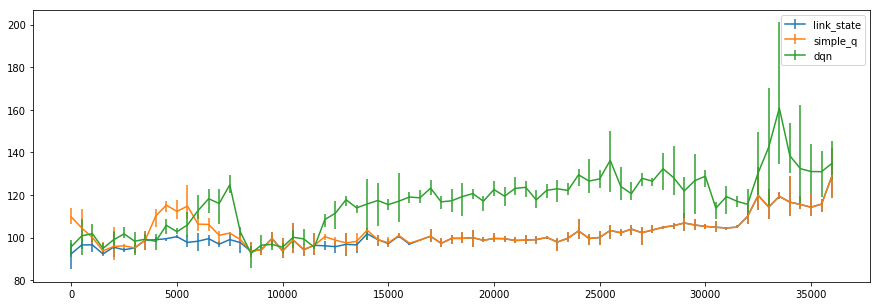

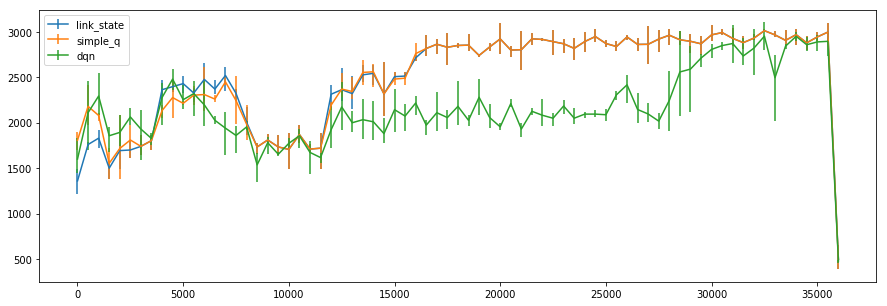

In [22]:
conveyor2_data_time, conveyor2_data_nrg = conveyor2_data_full
conveyor2_data_time_comb = combine_launch_data(conveyor2_data_time)
conveyor2_data_nrg_comb = combine_launch_data(conveyor2_data_nrg, target='sum')

plot_data(**conveyor2_data_time_comb)
plot_data(**conveyor2_data_nrg_comb, target='sum')